In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [3]:
dataset = pd.read_csv('../../data/pollution.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [4]:
print(dataset.columns)

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE',
       'NW', 'SE', 'cv'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['pollution']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (43800, 1)
stages_supervised.shape: (43705, 96)


In [7]:
stages_supervised

,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05 00:00:00,129.0,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,...,41.0,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0
2010-01-05 01:00:00,148.0,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,...,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0
2010-01-05 02:00:00,159.0,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,...,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0
2010-01-05 03:00:00,181.0,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,...,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0
2010-01-05 04:00:00,138.0,109.0,105.0,124.0,120.0,132.0,140.0,152.0,148.0,164.0,...,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-30 20:00:00,349.0,327.0,348.0,363.0,385.0,393.0,388.0,444.0,334.0,284.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
2014-12-30 21:00:00,327.0,348.0,363.0,385.0,393.0,388.0,444.0,334.0,284.0,264.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
2014-12-30 22:00:00,348.0,363.0,385.0,393.0,388.0,444.0,334.0,284.0,264.0,221.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0


#### Prior unknown covariates (6)

In [8]:
# prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
# print("prior_unknown.shape:", prior_unknown.shape)

# prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, K)
# print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

In [9]:
# prior_unknown_supervised

#### Prior known covariates (9)

In [10]:
prior_known = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, K)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (43800, 10)
prior_known_supervised.shape: (43705, 960)


In [11]:
# prior_known_supervised

### N_out, N_in, K

In [12]:
past_cov = dataset[['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE', 'NW', 'SE', 'cv']]

past_cov_supervised = series_to_supervised(past_cov, n_hours, K)
print("past_cov_supervised.shape:", past_cov_supervised.shape)

past_cov_supervised.shape: (43705, 960)


In [13]:
# past_cov_supervised  # 6 + 9 = 15 features

In [14]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [15]:
# past_ws_supervised  # 4

In [16]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*past_cov.shape[1]:(i+1)*past_cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [17]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised, past_ws_supervised], axis=1)
past_cov_ws_supervised = past_cov_ws_supervised[columns]


In [18]:
# past_cov_ws_supervised

In [19]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, K*prior_known.shape[1]:]  # shift 2 days for prior known covariates
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var10(t-48),...,shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23),shift_prior_known_supervised_var10(t+23)
0,-7.0,-6.0,1027.0,58.56,4.0,0.0,0.0,0.0,1.0,0.0,...,-22.0,-16.0,1033.0,23.70,0.0,0.0,0.0,1.0,0.0,0.0
1,-8.0,-6.0,1026.0,61.69,5.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-17.0,1033.0,26.83,0.0,0.0,0.0,1.0,0.0,0.0
2,-8.0,-7.0,1026.0,65.71,6.0,0.0,0.0,0.0,1.0,0.0,...,-25.0,-14.0,1033.0,4.02,0.0,0.0,1.0,0.0,0.0,0.0
3,-8.0,-7.0,1025.0,68.84,7.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-14.0,1034.0,8.04,0.0,0.0,1.0,0.0,0.0,0.0
4,-8.0,-7.0,1024.0,72.86,8.0,0.0,0.0,0.0,1.0,0.0,...,-26.0,-14.0,1033.0,13.85,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,-13.0,3.0,1017.0,0.89,0.0,0.0,0.0,0.0,0.0,1.0,...,-23.0,-2.0,1034.0,231.97,0.0,0.0,0.0,1.0,0.0,0.0
43701,-13.0,1.0,1017.0,1.78,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,237.78,0.0,0.0,0.0,1.0,0.0,0.0
43702,-10.0,2.0,1017.0,2.67,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-3.0,1034.0,242.70,0.0,0.0,0.0,1.0,0.0,0.0
43703,-10.0,-2.0,1017.0,3.12,0.0,0.0,0.0,0.0,0.0,1.0,...,-22.0,-4.0,1034.0,246.72,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
shift_prior_known_past_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], axis=1)


In [21]:
# shift_prior_known_past_cov_ws_supervised

In [22]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),...,var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23)
0,30.0,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,...,41.0,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0
1,34.0,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,...,33.0,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0
2,27.0,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,...,50.0,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0
3,25.0,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,...,56.0,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0
4,28.0,28.0,27.0,27.0,27.0,29.0,36.0,30.0,27.0,39.0,...,59.0,60.0,84.0,106.0,66.0,50.0,56.0,77.0,50.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43700,26.0,20.0,8.0,16.0,10.0,11.0,20.0,9.0,8.0,9.0,...,7.0,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0
43701,20.0,8.0,16.0,10.0,11.0,20.0,9.0,8.0,9.0,8.0,...,12.0,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0
43702,8.0,16.0,10.0,11.0,20.0,9.0,8.0,9.0,8.0,8.0,...,17.0,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0
43703,16.0,10.0,11.0,20.0,9.0,8.0,9.0,8.0,8.0,8.0,...,11.0,9.0,11.0,8.0,9.0,10.0,8.0,10.0,10.0,8.0


### Concatenation

In [23]:
all_data = concat([shift_prior_known_past_cov_ws_supervised, future_ws_supervised], axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (43705, 1536)


### Train & Test set

In [24]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 34964


In [25]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

1512

### Normalization

In [26]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (34964, 1512) (34964, 24) (8741, 1512) (8741, 24)


In [27]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (34964, 72, 21) (34964, 24) (8741, 72, 21) (8741, 24)


### Model

In [29]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

x1 = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)
x1 = layers.Conv1D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1)
x1 = layers.Conv1D(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1)
x1 = layers.Conv1D(filters=32, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1)


# merge = concatenate([model_input, x1])
x = layers.Flatten()(x1)
x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
x = Dense(64, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(64, activation='relu')(x)
x = Dense(train_y.shape[1])(x)

pm25_pararcnn = Model(model_input, x)
pm25_pararcnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 72, 21)]          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 72, 256)           11008     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 72, 128)           65664     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 72, 64)            16448     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 72, 32)            4128      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               5900

Epoch 1/6000


2023-02-05 22:57:46.243401: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-05 22:57:46.494439: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7



Epoch 00001: val_mae improved from inf to 0.07554, saving model to saved_model/pm25_cnn_sc1_4layer_24h_no_sc.h5
69/69 - 2s - loss: 0.1681 - mae: 0.0632 - val_loss: 0.1098 - val_mae: 0.0755
Epoch 2/6000

Epoch 00002: val_mae improved from 0.07554 to 0.07007, saving model to saved_model/pm25_cnn_sc1_4layer_24h_no_sc.h5
69/69 - 1s - loss: 0.0721 - mae: 0.0494 - val_loss: 0.0588 - val_mae: 0.0701
Epoch 3/6000

Epoch 00003: val_mae improved from 0.07007 to 0.06495, saving model to saved_model/pm25_cnn_sc1_4layer_24h_no_sc.h5
69/69 - 1s - loss: 0.0420 - mae: 0.0460 - val_loss: 0.0391 - val_mae: 0.0650
Epoch 4/6000

Epoch 00004: val_mae did not improve from 0.06495
69/69 - 1s - loss: 0.0294 - mae: 0.0454 - val_loss: 0.0304 - val_mae: 0.0650
Epoch 5/6000

Epoch 00005: val_mae improved from 0.06495 to 0.06461, saving model to saved_model/pm25_cnn_sc1_4layer_24h_no_sc.h5
69/69 - 1s - loss: 0.0230 - mae: 0.0441 - val_loss: 0.0255 - val_mae: 0.0646
Epoch 6/6000

Epoch 00006: val_mae did not impro

Epoch 49/6000

Epoch 00049: val_mae did not improve from 0.05581
69/69 - 1s - loss: 0.0056 - mae: 0.0390 - val_loss: 0.0095 - val_mae: 0.0597
Epoch 50/6000

Epoch 00050: val_mae did not improve from 0.05581
69/69 - 1s - loss: 0.0055 - mae: 0.0387 - val_loss: 0.0097 - val_mae: 0.0564
Epoch 51/6000

Epoch 00051: val_mae did not improve from 0.05581
69/69 - 1s - loss: 0.0054 - mae: 0.0385 - val_loss: 0.0098 - val_mae: 0.0563
Epoch 52/6000

Epoch 00052: val_mae improved from 0.05581 to 0.05538, saving model to saved_model/pm25_cnn_sc1_4layer_24h_no_sc.h5
69/69 - 1s - loss: 0.0054 - mae: 0.0384 - val_loss: 0.0094 - val_mae: 0.0554
Epoch 53/6000

Epoch 00053: val_mae did not improve from 0.05538
69/69 - 1s - loss: 0.0054 - mae: 0.0382 - val_loss: 0.0092 - val_mae: 0.0561
Epoch 54/6000

Epoch 00054: val_mae did not improve from 0.05538
69/69 - 1s - loss: 0.0054 - mae: 0.0383 - val_loss: 0.0098 - val_mae: 0.0569
Epoch 55/6000

Epoch 00055: val_mae did not improve from 0.05538
69/69 - 1s - loss

Epoch 101/6000

Epoch 00101: val_mae did not improve from 0.05303
69/69 - 1s - loss: 0.0046 - mae: 0.0367 - val_loss: 0.0083 - val_mae: 0.0556
Epoch 102/6000

Epoch 00102: val_mae did not improve from 0.05303
69/69 - 1s - loss: 0.0046 - mae: 0.0367 - val_loss: 0.0082 - val_mae: 0.0537
Epoch 103/6000

Epoch 00103: val_mae did not improve from 0.05303
69/69 - 1s - loss: 0.0046 - mae: 0.0366 - val_loss: 0.0082 - val_mae: 0.0535
Epoch 104/6000

Epoch 00104: val_mae did not improve from 0.05303
69/69 - 1s - loss: 0.0046 - mae: 0.0367 - val_loss: 0.0082 - val_mae: 0.0543
Epoch 105/6000

Epoch 00105: val_mae did not improve from 0.05303
69/69 - 1s - loss: 0.0046 - mae: 0.0368 - val_loss: 0.0082 - val_mae: 0.0531
Epoch 106/6000

Epoch 00106: val_mae did not improve from 0.05303
69/69 - 1s - loss: 0.0046 - mae: 0.0366 - val_loss: 0.0083 - val_mae: 0.0532
Epoch 107/6000

Epoch 00107: val_mae did not improve from 0.05303
69/69 - 1s - loss: 0.0046 - mae: 0.0366 - val_loss: 0.0081 - val_mae: 0.0532

Epoch 157/6000

Epoch 00157: val_mae did not improve from 0.05269
69/69 - 1s - loss: 0.0043 - mae: 0.0361 - val_loss: 0.0079 - val_mae: 0.0532
Epoch 158/6000

Epoch 00158: val_mae did not improve from 0.05269
69/69 - 1s - loss: 0.0043 - mae: 0.0361 - val_loss: 0.0079 - val_mae: 0.0538
Epoch 159/6000

Epoch 00159: val_mae did not improve from 0.05269
69/69 - 1s - loss: 0.0043 - mae: 0.0363 - val_loss: 0.0079 - val_mae: 0.0530
Epoch 160/6000

Epoch 00160: val_mae did not improve from 0.05269
69/69 - 1s - loss: 0.0043 - mae: 0.0360 - val_loss: 0.0079 - val_mae: 0.0549
Epoch 161/6000

Epoch 00161: val_mae did not improve from 0.05269
69/69 - 1s - loss: 0.0043 - mae: 0.0362 - val_loss: 0.0079 - val_mae: 0.0528
Epoch 162/6000

Epoch 00162: val_mae did not improve from 0.05269
69/69 - 1s - loss: 0.0043 - mae: 0.0364 - val_loss: 0.0079 - val_mae: 0.0528
Epoch 163/6000

Epoch 00163: val_mae did not improve from 0.05269
69/69 - 1s - loss: 0.0043 - mae: 0.0363 - val_loss: 0.0079 - val_mae: 0.0538


Epoch 00211: val_mae did not improve from 0.05199
69/69 - 1s - loss: 0.0041 - mae: 0.0357 - val_loss: 0.0078 - val_mae: 0.0538
Epoch 212/6000

Epoch 00212: val_mae did not improve from 0.05199
69/69 - 1s - loss: 0.0042 - mae: 0.0360 - val_loss: 0.0077 - val_mae: 0.0526
Epoch 213/6000

Epoch 00213: val_mae did not improve from 0.05199
69/69 - 1s - loss: 0.0042 - mae: 0.0360 - val_loss: 0.0079 - val_mae: 0.0552
Epoch 214/6000

Epoch 00214: val_mae did not improve from 0.05199
69/69 - 1s - loss: 0.0042 - mae: 0.0359 - val_loss: 0.0077 - val_mae: 0.0530
Epoch 215/6000

Epoch 00215: val_mae did not improve from 0.05199
69/69 - 1s - loss: 0.0041 - mae: 0.0358 - val_loss: 0.0077 - val_mae: 0.0527
Epoch 216/6000

Epoch 00216: val_mae did not improve from 0.05199
69/69 - 1s - loss: 0.0041 - mae: 0.0358 - val_loss: 0.0076 - val_mae: 0.0525
Epoch 217/6000

Epoch 00217: val_mae did not improve from 0.05199
69/69 - 1s - loss: 0.0042 - mae: 0.0359 - val_loss: 0.0077 - val_mae: 0.0528
Epoch 218/6000


Epoch 00267: val_mae did not improve from 0.05168
69/69 - 1s - loss: 0.0041 - mae: 0.0355 - val_loss: 0.0077 - val_mae: 0.0523
Epoch 268/6000

Epoch 00268: val_mae did not improve from 0.05168
69/69 - 1s - loss: 0.0041 - mae: 0.0356 - val_loss: 0.0075 - val_mae: 0.0521
Epoch 269/6000

Epoch 00269: val_mae did not improve from 0.05168
69/69 - 1s - loss: 0.0041 - mae: 0.0355 - val_loss: 0.0075 - val_mae: 0.0521
Epoch 270/6000

Epoch 00270: val_mae did not improve from 0.05168
69/69 - 1s - loss: 0.0041 - mae: 0.0356 - val_loss: 0.0075 - val_mae: 0.0521
Epoch 271/6000

Epoch 00271: val_mae did not improve from 0.05168
69/69 - 1s - loss: 0.0041 - mae: 0.0356 - val_loss: 0.0077 - val_mae: 0.0546
Epoch 272/6000

Epoch 00272: val_mae did not improve from 0.05168
69/69 - 1s - loss: 0.0041 - mae: 0.0357 - val_loss: 0.0076 - val_mae: 0.0535
Epoch 273/6000

Epoch 00273: val_mae did not improve from 0.05168
69/69 - 1s - loss: 0.0041 - mae: 0.0357 - val_loss: 0.0076 - val_mae: 0.0532
Epoch 274/6000


Epoch 00323: val_mae did not improve from 0.05137
69/69 - 1s - loss: 0.0040 - mae: 0.0353 - val_loss: 0.0075 - val_mae: 0.0521
Epoch 324/6000

Epoch 00324: val_mae did not improve from 0.05137
69/69 - 1s - loss: 0.0040 - mae: 0.0353 - val_loss: 0.0075 - val_mae: 0.0524
Epoch 325/6000

Epoch 00325: val_mae did not improve from 0.05137
69/69 - 1s - loss: 0.0040 - mae: 0.0353 - val_loss: 0.0075 - val_mae: 0.0526
Epoch 326/6000

Epoch 00326: val_mae did not improve from 0.05137
69/69 - 1s - loss: 0.0040 - mae: 0.0353 - val_loss: 0.0077 - val_mae: 0.0541
Epoch 327/6000

Epoch 00327: val_mae did not improve from 0.05137
69/69 - 1s - loss: 0.0040 - mae: 0.0357 - val_loss: 0.0075 - val_mae: 0.0515
Epoch 328/6000

Epoch 00328: val_mae did not improve from 0.05137
69/69 - 1s - loss: 0.0040 - mae: 0.0354 - val_loss: 0.0075 - val_mae: 0.0522
Epoch 329/6000

Epoch 00329: val_mae did not improve from 0.05137
69/69 - 1s - loss: 0.0040 - mae: 0.0354 - val_loss: 0.0075 - val_mae: 0.0528
Epoch 330/6000

Epoch 380/6000

Epoch 00380: val_mae did not improve from 0.05118
69/69 - 1s - loss: 0.0039 - mae: 0.0352 - val_loss: 0.0074 - val_mae: 0.0515
Epoch 381/6000

Epoch 00381: val_mae did not improve from 0.05118
69/69 - 1s - loss: 0.0039 - mae: 0.0353 - val_loss: 0.0074 - val_mae: 0.0518
Epoch 382/6000

Epoch 00382: val_mae did not improve from 0.05118
69/69 - 1s - loss: 0.0039 - mae: 0.0351 - val_loss: 0.0075 - val_mae: 0.0514
Epoch 383/6000

Epoch 00383: val_mae did not improve from 0.05118
69/69 - 1s - loss: 0.0040 - mae: 0.0354 - val_loss: 0.0074 - val_mae: 0.0516
Epoch 384/6000

Epoch 00384: val_mae did not improve from 0.05118
69/69 - 1s - loss: 0.0039 - mae: 0.0352 - val_loss: 0.0075 - val_mae: 0.0515
Epoch 385/6000

Epoch 00385: val_mae did not improve from 0.05118
69/69 - 1s - loss: 0.0039 - mae: 0.0352 - val_loss: 0.0075 - val_mae: 0.0523
Epoch 386/6000

Epoch 00386: val_mae did not improve from 0.05118
69/69 - 1s - loss: 0.0039 - mae: 0.0351 - val_loss: 0.0074 - val_mae: 0.0514

Epoch 438/6000

Epoch 00438: val_mae did not improve from 0.05118
69/69 - 1s - loss: 0.0039 - mae: 0.0351 - val_loss: 0.0075 - val_mae: 0.0532
Epoch 439/6000

Epoch 00439: val_mae improved from 0.05118 to 0.05115, saving model to saved_model/pm25_cnn_sc1_4layer_24h_no_sc.h5
69/69 - 1s - loss: 0.0039 - mae: 0.0351 - val_loss: 0.0074 - val_mae: 0.0511
Epoch 440/6000

Epoch 00440: val_mae did not improve from 0.05115
69/69 - 1s - loss: 0.0039 - mae: 0.0351 - val_loss: 0.0073 - val_mae: 0.0516
Epoch 441/6000

Epoch 00441: val_mae did not improve from 0.05115
69/69 - 1s - loss: 0.0039 - mae: 0.0350 - val_loss: 0.0074 - val_mae: 0.0514
Epoch 442/6000

Epoch 00442: val_mae did not improve from 0.05115
69/69 - 1s - loss: 0.0039 - mae: 0.0350 - val_loss: 0.0074 - val_mae: 0.0524
Epoch 443/6000

Epoch 00443: val_mae did not improve from 0.05115
69/69 - 1s - loss: 0.0039 - mae: 0.0352 - val_loss: 0.0074 - val_mae: 0.0518
Epoch 444/6000

Epoch 00444: val_mae did not improve from 0.05115
69/69 - 1s

Epoch 494/6000

Epoch 00494: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0039 - mae: 0.0350 - val_loss: 0.0074 - val_mae: 0.0517
Epoch 495/6000

Epoch 00495: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0039 - mae: 0.0350 - val_loss: 0.0074 - val_mae: 0.0511
Epoch 496/6000

Epoch 00496: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0039 - mae: 0.0349 - val_loss: 0.0073 - val_mae: 0.0514
Epoch 497/6000

Epoch 00497: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0039 - mae: 0.0350 - val_loss: 0.0075 - val_mae: 0.0516
Epoch 498/6000

Epoch 00498: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0039 - mae: 0.0349 - val_loss: 0.0074 - val_mae: 0.0520
Epoch 499/6000

Epoch 00499: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0039 - mae: 0.0348 - val_loss: 0.0073 - val_mae: 0.0512
Epoch 500/6000

Epoch 00500: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0039 - mae: 0.0350 - val_loss: 0.0077 - val_mae: 0.0540

Epoch 551/6000

Epoch 00551: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0348 - val_loss: 0.0075 - val_mae: 0.0527
Epoch 552/6000

Epoch 00552: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0347 - val_loss: 0.0074 - val_mae: 0.0511
Epoch 553/6000

Epoch 00553: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0348 - val_loss: 0.0075 - val_mae: 0.0528
Epoch 554/6000

Epoch 00554: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0347 - val_loss: 0.0074 - val_mae: 0.0514
Epoch 555/6000

Epoch 00555: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0039 - mae: 0.0349 - val_loss: 0.0075 - val_mae: 0.0513
Epoch 556/6000

Epoch 00556: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0039 - mae: 0.0352 - val_loss: 0.0075 - val_mae: 0.0519
Epoch 557/6000

Epoch 00557: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0348 - val_loss: 0.0076 - val_mae: 0.0534

Epoch 609/6000

Epoch 00609: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0346 - val_loss: 0.0074 - val_mae: 0.0514
Epoch 610/6000

Epoch 00610: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0347 - val_loss: 0.0075 - val_mae: 0.0524
Epoch 611/6000

Epoch 00611: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0347 - val_loss: 0.0073 - val_mae: 0.0510
Epoch 612/6000

Epoch 00612: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0346 - val_loss: 0.0074 - val_mae: 0.0509
Epoch 613/6000

Epoch 00613: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0347 - val_loss: 0.0073 - val_mae: 0.0517
Epoch 614/6000

Epoch 00614: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0348 - val_loss: 0.0074 - val_mae: 0.0522
Epoch 615/6000

Epoch 00615: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0347 - val_loss: 0.0075 - val_mae: 0.0523

Epoch 667/6000

Epoch 00667: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0347 - val_loss: 0.0073 - val_mae: 0.0509
Epoch 668/6000

Epoch 00668: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0347 - val_loss: 0.0076 - val_mae: 0.0535
Epoch 669/6000

Epoch 00669: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0347 - val_loss: 0.0077 - val_mae: 0.0538
Epoch 670/6000

Epoch 00670: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0347 - val_loss: 0.0074 - val_mae: 0.0518
Epoch 671/6000

Epoch 00671: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0346 - val_loss: 0.0074 - val_mae: 0.0511
Epoch 672/6000

Epoch 00672: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0346 - val_loss: 0.0074 - val_mae: 0.0513
Epoch 673/6000

Epoch 00673: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0346 - val_loss: 0.0073 - val_mae: 0.0512

Epoch 725/6000

Epoch 00725: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0346 - val_loss: 0.0073 - val_mae: 0.0512
Epoch 726/6000

Epoch 00726: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0346 - val_loss: 0.0074 - val_mae: 0.0515
Epoch 727/6000

Epoch 00727: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0346 - val_loss: 0.0076 - val_mae: 0.0536
Epoch 728/6000

Epoch 00728: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0347 - val_loss: 0.0073 - val_mae: 0.0515
Epoch 729/6000

Epoch 00729: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0346 - val_loss: 0.0074 - val_mae: 0.0519
Epoch 730/6000

Epoch 00730: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0345 - val_loss: 0.0073 - val_mae: 0.0514
Epoch 731/6000

Epoch 00731: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0346 - val_loss: 0.0075 - val_mae: 0.0521

Epoch 783/6000

Epoch 00783: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0345 - val_loss: 0.0073 - val_mae: 0.0508
Epoch 784/6000

Epoch 00784: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0345 - val_loss: 0.0074 - val_mae: 0.0517
Epoch 785/6000

Epoch 00785: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0345 - val_loss: 0.0073 - val_mae: 0.0510
Epoch 786/6000

Epoch 00786: val_mae did not improve from 0.05079
69/69 - 1s - loss: 0.0038 - mae: 0.0345 - val_loss: 0.0075 - val_mae: 0.0528
Epoch 787/6000

Epoch 00787: val_mae improved from 0.05079 to 0.05076, saving model to saved_model/pm25_cnn_sc1_4layer_24h_no_sc.h5
69/69 - 1s - loss: 0.0038 - mae: 0.0345 - val_loss: 0.0073 - val_mae: 0.0508
Epoch 788/6000

Epoch 00788: val_mae did not improve from 0.05076
69/69 - 1s - loss: 0.0038 - mae: 0.0345 - val_loss: 0.0073 - val_mae: 0.0515
Epoch 789/6000

Epoch 00789: val_mae did not improve from 0.05076
69/69 - 1s

Epoch 840/6000

Epoch 00840: val_mae did not improve from 0.05076
69/69 - 1s - loss: 0.0037 - mae: 0.0345 - val_loss: 0.0073 - val_mae: 0.0512
Epoch 841/6000

Epoch 00841: val_mae did not improve from 0.05076
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0074 - val_mae: 0.0514
Epoch 842/6000

Epoch 00842: val_mae did not improve from 0.05076
69/69 - 1s - loss: 0.0038 - mae: 0.0346 - val_loss: 0.0074 - val_mae: 0.0511
Epoch 843/6000

Epoch 00843: val_mae did not improve from 0.05076
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0075 - val_mae: 0.0534
Epoch 844/6000

Epoch 00844: val_mae did not improve from 0.05076
69/69 - 1s - loss: 0.0038 - mae: 0.0345 - val_loss: 0.0074 - val_mae: 0.0518
Epoch 845/6000

Epoch 00845: val_mae did not improve from 0.05076
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0075 - val_mae: 0.0526
Epoch 846/6000

Epoch 00846: val_mae did not improve from 0.05076
69/69 - 1s - loss: 0.0038 - mae: 0.0345 - val_loss: 0.0074 - val_mae: 0.0514

Epoch 897/6000

Epoch 00897: val_mae did not improve from 0.05072
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0513
Epoch 898/6000

Epoch 00898: val_mae did not improve from 0.05072
69/69 - 1s - loss: 0.0037 - mae: 0.0345 - val_loss: 0.0073 - val_mae: 0.0513
Epoch 899/6000

Epoch 00899: val_mae did not improve from 0.05072
69/69 - 1s - loss: 0.0037 - mae: 0.0345 - val_loss: 0.0073 - val_mae: 0.0509
Epoch 900/6000

Epoch 00900: val_mae did not improve from 0.05072
69/69 - 1s - loss: 0.0037 - mae: 0.0345 - val_loss: 0.0077 - val_mae: 0.0539
Epoch 901/6000

Epoch 00901: val_mae did not improve from 0.05072
69/69 - 1s - loss: 0.0038 - mae: 0.0346 - val_loss: 0.0074 - val_mae: 0.0513
Epoch 902/6000

Epoch 00902: val_mae did not improve from 0.05072
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0074 - val_mae: 0.0514
Epoch 903/6000

Epoch 00903: val_mae did not improve from 0.05072
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0076 - val_mae: 0.0536

Epoch 955/6000

Epoch 00955: val_mae did not improve from 0.05072
69/69 - 1s - loss: 0.0037 - mae: 0.0345 - val_loss: 0.0073 - val_mae: 0.0518
Epoch 956/6000

Epoch 00956: val_mae did not improve from 0.05072
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0074 - val_mae: 0.0527
Epoch 957/6000

Epoch 00957: val_mae did not improve from 0.05072
69/69 - 1s - loss: 0.0037 - mae: 0.0345 - val_loss: 0.0074 - val_mae: 0.0516
Epoch 958/6000

Epoch 00958: val_mae did not improve from 0.05072
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0074 - val_mae: 0.0524
Epoch 959/6000

Epoch 00959: val_mae did not improve from 0.05072
69/69 - 1s - loss: 0.0038 - mae: 0.0347 - val_loss: 0.0074 - val_mae: 0.0512
Epoch 960/6000

Epoch 00960: val_mae did not improve from 0.05072
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0073 - val_mae: 0.0512
Epoch 961/6000

Epoch 00961: val_mae did not improve from 0.05072
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0074 - val_mae: 0.0515

Epoch 1012/6000

Epoch 01012: val_mae did not improve from 0.05071
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0073 - val_mae: 0.0514
Epoch 1013/6000

Epoch 01013: val_mae did not improve from 0.05071
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0512
Epoch 1014/6000

Epoch 01014: val_mae did not improve from 0.05071
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0515
Epoch 1015/6000

Epoch 01015: val_mae did not improve from 0.05071
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0073 - val_mae: 0.0513
Epoch 1016/6000

Epoch 01016: val_mae did not improve from 0.05071
69/69 - 1s - loss: 0.0037 - mae: 0.0346 - val_loss: 0.0074 - val_mae: 0.0509
Epoch 1017/6000

Epoch 01017: val_mae did not improve from 0.05071
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0074 - val_mae: 0.0510
Epoch 1018/6000

Epoch 01018: val_mae did not improve from 0.05071
69/69 - 1s - loss: 0.0037 - mae: 0.0346 - val_loss: 0.0073 - val_mae:

Epoch 1069/6000

Epoch 01069: val_mae did not improve from 0.05068
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0514
Epoch 1070/6000

Epoch 01070: val_mae did not improve from 0.05068
69/69 - 1s - loss: 0.0037 - mae: 0.0345 - val_loss: 0.0073 - val_mae: 0.0509
Epoch 1071/6000

Epoch 01071: val_mae did not improve from 0.05068
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0074 - val_mae: 0.0516
Epoch 1072/6000

Epoch 01072: val_mae did not improve from 0.05068
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0076 - val_mae: 0.0533
Epoch 1073/6000

Epoch 01073: val_mae did not improve from 0.05068
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0075 - val_mae: 0.0526
Epoch 1074/6000

Epoch 01074: val_mae did not improve from 0.05068
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0073 - val_mae: 0.0518
Epoch 1075/6000

Epoch 01075: val_mae did not improve from 0.05068
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae:

Epoch 1126/6000

Epoch 01126: val_mae did not improve from 0.05060
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0507
Epoch 1127/6000

Epoch 01127: val_mae did not improve from 0.05060
69/69 - 1s - loss: 0.0037 - mae: 0.0345 - val_loss: 0.0074 - val_mae: 0.0520
Epoch 1128/6000

Epoch 01128: val_mae did not improve from 0.05060
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0074 - val_mae: 0.0516
Epoch 1129/6000

Epoch 01129: val_mae did not improve from 0.05060
69/69 - 1s - loss: 0.0037 - mae: 0.0342 - val_loss: 0.0073 - val_mae: 0.0509
Epoch 1130/6000

Epoch 01130: val_mae did not improve from 0.05060
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0075 - val_mae: 0.0524
Epoch 1131/6000

Epoch 01131: val_mae did not improve from 0.05060
69/69 - 1s - loss: 0.0037 - mae: 0.0345 - val_loss: 0.0074 - val_mae: 0.0517
Epoch 1132/6000

Epoch 01132: val_mae did not improve from 0.05060
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae:

Epoch 1183/6000

Epoch 01183: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0513
Epoch 1184/6000

Epoch 01184: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0074 - val_mae: 0.0520
Epoch 1185/6000

Epoch 01185: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0074 - val_mae: 0.0512
Epoch 1186/6000

Epoch 01186: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0074 - val_mae: 0.0521
Epoch 1187/6000

Epoch 01187: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0074 - val_mae: 0.0523
Epoch 1188/6000

Epoch 01188: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0345 - val_loss: 0.0075 - val_mae: 0.0518
Epoch 1189/6000

Epoch 01189: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0074 - val_mae:

Epoch 1240/6000

Epoch 01240: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0075 - val_mae: 0.0530
Epoch 1241/6000

Epoch 01241: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0073 - val_mae: 0.0511
Epoch 1242/6000

Epoch 01242: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0517
Epoch 1243/6000

Epoch 01243: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0511
Epoch 1244/6000

Epoch 01244: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0342 - val_loss: 0.0075 - val_mae: 0.0524
Epoch 1245/6000

Epoch 01245: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0342 - val_loss: 0.0074 - val_mae: 0.0521
Epoch 1246/6000

Epoch 01246: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae:

Epoch 1297/6000

Epoch 01297: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0342 - val_loss: 0.0073 - val_mae: 0.0509
Epoch 1298/6000

Epoch 01298: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0342 - val_loss: 0.0073 - val_mae: 0.0511
Epoch 1299/6000

Epoch 01299: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0345 - val_loss: 0.0073 - val_mae: 0.0516
Epoch 1300/6000

Epoch 01300: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0514
Epoch 1301/6000

Epoch 01301: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0073 - val_mae: 0.0509
Epoch 1302/6000

Epoch 01302: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0342 - val_loss: 0.0074 - val_mae: 0.0515
Epoch 1303/6000

Epoch 01303: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0075 - val_mae:

Epoch 1354/6000

Epoch 01354: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0510
Epoch 1355/6000

Epoch 01355: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0072 - val_mae: 0.0508
Epoch 1356/6000

Epoch 01356: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0342 - val_loss: 0.0076 - val_mae: 0.0534
Epoch 1357/6000

Epoch 01357: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0074 - val_mae: 0.0511
Epoch 1358/6000

Epoch 01358: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0342 - val_loss: 0.0074 - val_mae: 0.0523
Epoch 1359/6000

Epoch 01359: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0073 - val_mae: 0.0509
Epoch 1360/6000

Epoch 01360: val_mae did not improve from 0.05057
69/69 - 1s - loss: 0.0037 - mae: 0.0344 - val_loss: 0.0076 - val_mae:

Epoch 1411/6000

Epoch 01411: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0037 - mae: 0.0342 - val_loss: 0.0076 - val_mae: 0.0533
Epoch 1412/6000

Epoch 01412: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0509
Epoch 1413/6000

Epoch 01413: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0342 - val_loss: 0.0074 - val_mae: 0.0510
Epoch 1414/6000

Epoch 01414: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0342 - val_loss: 0.0073 - val_mae: 0.0510
Epoch 1415/6000

Epoch 01415: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0074 - val_mae: 0.0521
Epoch 1416/6000

Epoch 01416: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0514
Epoch 1417/6000

Epoch 01417: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0073 - val_mae:

Epoch 1468/6000

Epoch 01468: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0074 - val_mae: 0.0524
Epoch 1469/6000

Epoch 01469: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0342 - val_loss: 0.0075 - val_mae: 0.0528
Epoch 1470/6000

Epoch 01470: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0072 - val_mae: 0.0509
Epoch 1471/6000

Epoch 01471: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0075 - val_mae: 0.0525
Epoch 1472/6000

Epoch 01472: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0342 - val_loss: 0.0076 - val_mae: 0.0541
Epoch 1473/6000

Epoch 01473: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0074 - val_mae: 0.0517
Epoch 1474/6000

Epoch 01474: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0342 - val_loss: 0.0074 - val_mae:

Epoch 1525/6000

Epoch 01525: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0342 - val_loss: 0.0072 - val_mae: 0.0509
Epoch 1526/6000

Epoch 01526: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0073 - val_mae: 0.0511
Epoch 1527/6000

Epoch 01527: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0073 - val_mae: 0.0517
Epoch 1528/6000

Epoch 01528: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0507
Epoch 1529/6000

Epoch 01529: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 1530/6000

Epoch 01530: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0072 - val_mae: 0.0507
Epoch 1531/6000

Epoch 01531: val_mae did not improve from 0.05055
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0073 - val_mae:

Epoch 1582/6000

Epoch 01582: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0342 - val_loss: 0.0072 - val_mae: 0.0509
Epoch 1583/6000

Epoch 01583: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 1584/6000

Epoch 01584: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0342 - val_loss: 0.0074 - val_mae: 0.0517
Epoch 1585/6000

Epoch 01585: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0074 - val_mae: 0.0526
Epoch 1586/6000

Epoch 01586: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0073 - val_mae: 0.0509
Epoch 1587/6000

Epoch 01587: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 1588/6000

Epoch 01588: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0072 - val_mae:

Epoch 1639/6000

Epoch 01639: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0073 - val_mae: 0.0512
Epoch 1640/6000

Epoch 01640: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0075 - val_mae: 0.0532
Epoch 1641/6000

Epoch 01641: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0074 - val_mae: 0.0518
Epoch 1642/6000

Epoch 01642: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0342 - val_loss: 0.0072 - val_mae: 0.0508
Epoch 1643/6000

Epoch 01643: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0343 - val_loss: 0.0072 - val_mae: 0.0509
Epoch 1644/6000

Epoch 01644: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0075 - val_mae: 0.0536
Epoch 1645/6000

Epoch 01645: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0073 - val_mae:

Epoch 1696/6000

Epoch 01696: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0072 - val_mae: 0.0514
Epoch 1697/6000

Epoch 01697: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0073 - val_mae: 0.0514
Epoch 1698/6000

Epoch 01698: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0508
Epoch 1699/6000

Epoch 01699: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0072 - val_mae: 0.0505
Epoch 1700/6000

Epoch 01700: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0073 - val_mae: 0.0513
Epoch 1701/6000

Epoch 01701: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0513
Epoch 1702/6000

Epoch 01702: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0073 - val_mae:

Epoch 1753/6000

Epoch 01753: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0508
Epoch 1754/6000

Epoch 01754: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0508
Epoch 1755/6000

Epoch 01755: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0073 - val_mae: 0.0518
Epoch 1756/6000

Epoch 01756: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0338 - val_loss: 0.0075 - val_mae: 0.0528
Epoch 1757/6000

Epoch 01757: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0515
Epoch 1758/6000

Epoch 01758: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0073 - val_mae: 0.0515
Epoch 1759/6000

Epoch 01759: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0073 - val_mae:

Epoch 1810/6000

Epoch 01810: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 1811/6000

Epoch 01811: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0508
Epoch 1812/6000

Epoch 01812: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0338 - val_loss: 0.0076 - val_mae: 0.0531
Epoch 1813/6000

Epoch 01813: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0508
Epoch 1814/6000

Epoch 01814: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0075 - val_mae: 0.0525
Epoch 1815/6000

Epoch 01815: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0074 - val_mae: 0.0522
Epoch 1816/6000

Epoch 01816: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0073 - val_mae:

Epoch 1867/6000

Epoch 01867: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0073 - val_mae: 0.0514
Epoch 1868/6000

Epoch 01868: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0509
Epoch 1869/6000

Epoch 01869: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 1870/6000

Epoch 01870: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0518
Epoch 1871/6000

Epoch 01871: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0511
Epoch 1872/6000

Epoch 01872: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0343 - val_loss: 0.0073 - val_mae: 0.0511
Epoch 1873/6000

Epoch 01873: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0073 - val_mae:

Epoch 1924/6000

Epoch 01924: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0515
Epoch 1925/6000

Epoch 01925: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0514
Epoch 1926/6000

Epoch 01926: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0074 - val_mae: 0.0517
Epoch 1927/6000

Epoch 01927: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0075 - val_mae: 0.0529
Epoch 1928/6000

Epoch 01928: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0074 - val_mae: 0.0510
Epoch 1929/6000

Epoch 01929: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0073 - val_mae: 0.0517
Epoch 1930/6000

Epoch 01930: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0075 - val_mae:

Epoch 1981/6000

Epoch 01981: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0076 - val_mae: 0.0543
Epoch 1982/6000

Epoch 01982: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0072 - val_mae: 0.0515
Epoch 1983/6000

Epoch 01983: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0074 - val_mae: 0.0522
Epoch 1984/6000

Epoch 01984: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0512
Epoch 1985/6000

Epoch 01985: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0513
Epoch 1986/6000

Epoch 01986: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0075 - val_mae: 0.0531
Epoch 1987/6000

Epoch 01987: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0074 - val_mae:

Epoch 2038/6000

Epoch 02038: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0076 - val_mae: 0.0536
Epoch 2039/6000

Epoch 02039: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0073 - val_mae: 0.0519
Epoch 2040/6000

Epoch 02040: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0516
Epoch 2041/6000

Epoch 02041: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0507
Epoch 2042/6000

Epoch 02042: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 2043/6000

Epoch 02043: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0509
Epoch 2044/6000

Epoch 02044: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0073 - val_mae:

Epoch 2095/6000

Epoch 02095: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0073 - val_mae: 0.0514
Epoch 2096/6000

Epoch 02096: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0338 - val_loss: 0.0075 - val_mae: 0.0530
Epoch 2097/6000

Epoch 02097: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0074 - val_mae: 0.0522
Epoch 2098/6000

Epoch 02098: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0338 - val_loss: 0.0074 - val_mae: 0.0522
Epoch 2099/6000

Epoch 02099: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0506
Epoch 2100/6000

Epoch 02100: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0507
Epoch 2101/6000

Epoch 02101: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0075 - val_mae:

Epoch 2152/6000

Epoch 02152: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0513
Epoch 2153/6000

Epoch 02153: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0073 - val_mae: 0.0516
Epoch 2154/6000

Epoch 02154: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0077 - val_mae: 0.0543
Epoch 2155/6000

Epoch 02155: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0513
Epoch 2156/6000

Epoch 02156: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0076 - val_mae: 0.0535
Epoch 2157/6000

Epoch 02157: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 2158/6000

Epoch 02158: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae:

Epoch 2209/6000

Epoch 02209: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0513
Epoch 2210/6000

Epoch 02210: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0507
Epoch 2211/6000

Epoch 02211: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 2212/6000

Epoch 02212: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0513
Epoch 2213/6000

Epoch 02213: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0074 - val_mae: 0.0515
Epoch 2214/6000

Epoch 02214: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0519
Epoch 2215/6000

Epoch 02215: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae:

Epoch 2266/6000

Epoch 02266: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0519
Epoch 2267/6000

Epoch 02267: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 2268/6000

Epoch 02268: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0079 - val_mae: 0.0553
Epoch 2269/6000

Epoch 02269: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0508
Epoch 2270/6000

Epoch 02270: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0518
Epoch 2271/6000

Epoch 02271: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0515
Epoch 2272/6000

Epoch 02272: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0075 - val_mae:

Epoch 2323/6000

Epoch 02323: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0517
Epoch 2324/6000

Epoch 02324: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 2325/6000

Epoch 02325: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0074 - val_mae: 0.0521
Epoch 2326/6000

Epoch 02326: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0075 - val_mae: 0.0534
Epoch 2327/6000

Epoch 02327: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0342 - val_loss: 0.0072 - val_mae: 0.0514
Epoch 2328/6000

Epoch 02328: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0516
Epoch 2329/6000

Epoch 02329: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0074 - val_mae:

Epoch 2380/6000

Epoch 02380: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 2381/6000

Epoch 02381: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0076 - val_mae: 0.0539
Epoch 2382/6000

Epoch 02382: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 2383/6000

Epoch 02383: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0517
Epoch 2384/6000

Epoch 02384: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0509
Epoch 2385/6000

Epoch 02385: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 2386/6000

Epoch 02386: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae:

Epoch 2437/6000

Epoch 02437: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0514
Epoch 2438/6000

Epoch 02438: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0073 - val_mae: 0.0517
Epoch 2439/6000

Epoch 02439: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 2440/6000

Epoch 02440: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0516
Epoch 2441/6000

Epoch 02441: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 2442/6000

Epoch 02442: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0510
Epoch 2443/6000

Epoch 02443: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae:

Epoch 2494/6000

Epoch 02494: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0515
Epoch 2495/6000

Epoch 02495: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0075 - val_mae: 0.0531
Epoch 2496/6000

Epoch 02496: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 2497/6000

Epoch 02497: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 2498/6000

Epoch 02498: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0074 - val_mae: 0.0526
Epoch 2499/6000

Epoch 02499: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0075 - val_mae: 0.0530
Epoch 2500/6000

Epoch 02500: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae:

Epoch 2551/6000

Epoch 02551: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 2552/6000

Epoch 02552: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 2553/6000

Epoch 02553: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0527
Epoch 2554/6000

Epoch 02554: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 2555/6000

Epoch 02555: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0525
Epoch 2556/6000

Epoch 02556: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0519
Epoch 2557/6000

Epoch 02557: val_mae did not improve from 0.05048
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae:

Epoch 2608/6000

Epoch 02608: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0076 - val_mae: 0.0536
Epoch 2609/6000

Epoch 02609: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0075 - val_mae: 0.0546
Epoch 2610/6000

Epoch 02610: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0340 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 2611/6000

Epoch 02611: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0517
Epoch 2612/6000

Epoch 02612: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 2613/6000

Epoch 02613: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0519
Epoch 2614/6000

Epoch 02614: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0340 - val_loss: 0.0072 - val_mae:

Epoch 2665/6000

Epoch 02665: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 2666/6000

Epoch 02666: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0515
Epoch 2667/6000

Epoch 02667: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0074 - val_mae: 0.0518
Epoch 2668/6000

Epoch 02668: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0036 - mae: 0.0340 - val_loss: 0.0074 - val_mae: 0.0531
Epoch 2669/6000

Epoch 02669: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 2670/6000

Epoch 02670: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0074 - val_mae: 0.0527
Epoch 2671/6000

Epoch 02671: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae:

Epoch 2722/6000

Epoch 02722: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 2723/6000

Epoch 02723: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0515
Epoch 2724/6000

Epoch 02724: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 2725/6000

Epoch 02725: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0516
Epoch 2726/6000

Epoch 02726: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 2727/6000

Epoch 02727: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 2728/6000

Epoch 02728: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0036 - mae: 0.0341 - val_loss: 0.0072 - val_mae:

Epoch 2779/6000

Epoch 02779: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0518
Epoch 2780/6000

Epoch 02780: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 2781/6000

Epoch 02781: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0517
Epoch 2782/6000

Epoch 02782: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0512
Epoch 2783/6000

Epoch 02783: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0077 - val_mae: 0.0548
Epoch 2784/6000

Epoch 02784: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0514
Epoch 2785/6000

Epoch 02785: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0073 - val_mae:

Epoch 2836/6000

Epoch 02836: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0518
Epoch 2837/6000

Epoch 02837: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0523
Epoch 2838/6000

Epoch 02838: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0518
Epoch 2839/6000

Epoch 02839: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0071 - val_mae: 0.0514
Epoch 2840/6000

Epoch 02840: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0520
Epoch 2841/6000

Epoch 02841: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 2842/6000

Epoch 02842: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0074 - val_mae:

Epoch 2893/6000

Epoch 02893: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 2894/6000

Epoch 02894: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0509
Epoch 2895/6000

Epoch 02895: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 2896/6000

Epoch 02896: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0515
Epoch 2897/6000

Epoch 02897: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0516
Epoch 2898/6000

Epoch 02898: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0517
Epoch 2899/6000

Epoch 02899: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae:

Epoch 2950/6000

Epoch 02950: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0074 - val_mae: 0.0529
Epoch 2951/6000

Epoch 02951: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0517
Epoch 2952/6000

Epoch 02952: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 2953/6000

Epoch 02953: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0531
Epoch 2954/6000

Epoch 02954: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0508
Epoch 2955/6000

Epoch 02955: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 2956/6000

Epoch 02956: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0074 - val_mae:

Epoch 3007/6000

Epoch 03007: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 3008/6000

Epoch 03008: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0520
Epoch 3009/6000

Epoch 03009: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0074 - val_mae: 0.0525
Epoch 3010/6000

Epoch 03010: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 3011/6000

Epoch 03011: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 3012/6000

Epoch 03012: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 3013/6000

Epoch 03013: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0074 - val_mae:

Epoch 3064/6000

Epoch 03064: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 3065/6000

Epoch 03065: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 3066/6000

Epoch 03066: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 3067/6000

Epoch 03067: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0071 - val_mae: 0.0513
Epoch 3068/6000

Epoch 03068: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 3069/6000

Epoch 03069: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0522
Epoch 3070/6000

Epoch 03070: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0074 - val_mae:

Epoch 3121/6000

Epoch 03121: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0505
Epoch 3122/6000

Epoch 03122: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0519
Epoch 3123/6000

Epoch 03123: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 3124/6000

Epoch 03124: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0508
Epoch 3125/6000

Epoch 03125: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 3126/6000

Epoch 03126: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 3127/6000

Epoch 03127: val_mae did not improve from 0.05043
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae:

Epoch 3178/6000

Epoch 03178: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0527
Epoch 3179/6000

Epoch 03179: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0036 - mae: 0.0343 - val_loss: 0.0072 - val_mae: 0.0507
Epoch 3180/6000

Epoch 03180: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0517
Epoch 3181/6000

Epoch 03181: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 3182/6000

Epoch 03182: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0515
Epoch 3183/6000

Epoch 03183: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0507
Epoch 3184/6000

Epoch 03184: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae:

Epoch 3235/6000

Epoch 03235: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 3236/6000

Epoch 03236: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0509
Epoch 3237/6000

Epoch 03237: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0512
Epoch 3238/6000

Epoch 03238: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0519
Epoch 3239/6000

Epoch 03239: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0514
Epoch 3240/6000

Epoch 03240: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0516
Epoch 3241/6000

Epoch 03241: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae:

Epoch 3292/6000

Epoch 03292: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 3293/6000

Epoch 03293: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0523
Epoch 3294/6000

Epoch 03294: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 3295/6000

Epoch 03295: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 3296/6000

Epoch 03296: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0341 - val_loss: 0.0071 - val_mae: 0.0509
Epoch 3297/6000

Epoch 03297: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 3298/6000

Epoch 03298: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0072 - val_mae:

Epoch 3349/6000

Epoch 03349: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 3350/6000

Epoch 03350: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 3351/6000

Epoch 03351: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0509
Epoch 3352/6000

Epoch 03352: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 3353/6000

Epoch 03353: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0505
Epoch 3354/6000

Epoch 03354: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0340 - val_loss: 0.0072 - val_mae: 0.0519
Epoch 3355/6000

Epoch 03355: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae:

Epoch 3406/6000

Epoch 03406: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0517
Epoch 3407/6000

Epoch 03407: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 3408/6000

Epoch 03408: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0075 - val_mae: 0.0534
Epoch 3409/6000

Epoch 03409: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 3410/6000

Epoch 03410: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0514
Epoch 3411/6000

Epoch 03411: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 3412/6000

Epoch 03412: val_mae did not improve from 0.05040
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0071 - val_mae:

Epoch 3463/6000

Epoch 03463: val_mae did not improve from 0.05039
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 3464/6000

Epoch 03464: val_mae did not improve from 0.05039
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0521
Epoch 3465/6000

Epoch 03465: val_mae did not improve from 0.05039
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0522
Epoch 3466/6000

Epoch 03466: val_mae did not improve from 0.05039
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0509
Epoch 3467/6000

Epoch 03467: val_mae did not improve from 0.05039
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0521
Epoch 3468/6000

Epoch 03468: val_mae did not improve from 0.05039
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 3469/6000

Epoch 03469: val_mae did not improve from 0.05039
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0073 - val_mae:

Epoch 3520/6000

Epoch 03520: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0522
Epoch 3521/6000

Epoch 03521: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 3522/6000

Epoch 03522: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 3523/6000

Epoch 03523: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0517
Epoch 3524/6000

Epoch 03524: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 3525/6000

Epoch 03525: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0509
Epoch 3526/6000

Epoch 03526: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0071 - val_mae:

Epoch 3577/6000

Epoch 03577: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 3578/6000

Epoch 03578: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 3579/6000

Epoch 03579: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 3580/6000

Epoch 03580: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 3581/6000

Epoch 03581: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0509
Epoch 3582/6000

Epoch 03582: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0508
Epoch 3583/6000

Epoch 03583: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0073 - val_mae:

Epoch 3634/6000

Epoch 03634: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0509
Epoch 3635/6000

Epoch 03635: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0513
Epoch 3636/6000

Epoch 03636: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0515
Epoch 3637/6000

Epoch 03637: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 3638/6000

Epoch 03638: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0514
Epoch 3639/6000

Epoch 03639: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 3640/6000

Epoch 03640: val_mae did not improve from 0.05033
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae:

Epoch 3691/6000

Epoch 03691: val_mae did not improve from 0.05029
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 3692/6000

Epoch 03692: val_mae did not improve from 0.05029
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 3693/6000

Epoch 03693: val_mae did not improve from 0.05029
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0514
Epoch 3694/6000

Epoch 03694: val_mae did not improve from 0.05029
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0521
Epoch 3695/6000

Epoch 03695: val_mae did not improve from 0.05029
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0514
Epoch 3696/6000

Epoch 03696: val_mae did not improve from 0.05029
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0507
Epoch 3697/6000

Epoch 03697: val_mae did not improve from 0.05029
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0071 - val_mae:

Epoch 3748/6000

Epoch 03748: val_mae did not improve from 0.05029
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0520
Epoch 3749/6000

Epoch 03749: val_mae did not improve from 0.05029
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0525
Epoch 3750/6000

Epoch 03750: val_mae did not improve from 0.05029
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0517
Epoch 3751/6000

Epoch 03751: val_mae did not improve from 0.05029
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0074 - val_mae: 0.0526
Epoch 3752/6000

Epoch 03752: val_mae did not improve from 0.05029
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 3753/6000

Epoch 03753: val_mae did not improve from 0.05029
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0509
Epoch 3754/6000

Epoch 03754: val_mae did not improve from 0.05029
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0071 - val_mae:

Epoch 3805/6000

Epoch 03805: val_mae did not improve from 0.05028
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0071 - val_mae: 0.0505
Epoch 3806/6000

Epoch 03806: val_mae did not improve from 0.05028
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 3807/6000

Epoch 03807: val_mae did not improve from 0.05028
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 3808/6000

Epoch 03808: val_mae did not improve from 0.05028
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 3809/6000

Epoch 03809: val_mae improved from 0.05028 to 0.05024, saving model to saved_model/pm25_cnn_sc1_4layer_24h_no_sc.h5
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0070 - val_mae: 0.0502
Epoch 3810/6000

Epoch 03810: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 3811/6000

Epoch 03811: val_mae did not improve from 0.05024
69/

Epoch 3862/6000

Epoch 03862: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0522
Epoch 3863/6000

Epoch 03863: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0514
Epoch 3864/6000

Epoch 03864: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0075 - val_mae: 0.0537
Epoch 3865/6000

Epoch 03865: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0528
Epoch 3866/6000

Epoch 03866: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0073 - val_mae: 0.0530
Epoch 3867/6000

Epoch 03867: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 3868/6000

Epoch 03868: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0071 - val_mae:

Epoch 3919/6000

Epoch 03919: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 3920/6000

Epoch 03920: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0522
Epoch 3921/6000

Epoch 03921: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0340 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 3922/6000

Epoch 03922: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0073 - val_mae: 0.0526
Epoch 3923/6000

Epoch 03923: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0515
Epoch 3924/6000

Epoch 03924: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0074 - val_mae: 0.0532
Epoch 3925/6000

Epoch 03925: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae:

Epoch 3976/6000

Epoch 03976: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0524
Epoch 3977/6000

Epoch 03977: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0509
Epoch 3978/6000

Epoch 03978: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0508
Epoch 3979/6000

Epoch 03979: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 3980/6000

Epoch 03980: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 3981/6000

Epoch 03981: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0075 - val_mae: 0.0538
Epoch 3982/6000

Epoch 03982: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae:

Epoch 4033/6000

Epoch 04033: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 4034/6000

Epoch 04034: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 4035/6000

Epoch 04035: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0513
Epoch 4036/6000

Epoch 04036: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 4037/6000

Epoch 04037: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 4038/6000

Epoch 04038: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0514
Epoch 4039/6000

Epoch 04039: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0073 - val_mae:

Epoch 4090/6000

Epoch 04090: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 4091/6000

Epoch 04091: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0515
Epoch 4092/6000

Epoch 04092: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 4093/6000

Epoch 04093: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 4094/6000

Epoch 04094: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0508
Epoch 4095/6000

Epoch 04095: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0073 - val_mae: 0.0524
Epoch 4096/6000

Epoch 04096: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0071 - val_mae:

Epoch 4147/6000

Epoch 04147: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0519
Epoch 4148/6000

Epoch 04148: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0506
Epoch 4149/6000

Epoch 04149: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 4150/6000

Epoch 04150: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 4151/6000

Epoch 04151: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0506
Epoch 4152/6000

Epoch 04152: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 4153/6000

Epoch 04153: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae:

Epoch 4204/6000

Epoch 04204: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 4205/6000

Epoch 04205: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 4206/6000

Epoch 04206: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0071 - val_mae: 0.0506
Epoch 4207/6000

Epoch 04207: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 4208/6000

Epoch 04208: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0514
Epoch 4209/6000

Epoch 04209: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0506
Epoch 4210/6000

Epoch 04210: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae:

Epoch 4261/6000

Epoch 04261: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0519
Epoch 4262/6000

Epoch 04262: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0520
Epoch 4263/6000

Epoch 04263: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0505
Epoch 4264/6000

Epoch 04264: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 4265/6000

Epoch 04265: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 4266/6000

Epoch 04266: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0508
Epoch 4267/6000

Epoch 04267: val_mae did not improve from 0.05024
69/69 - 1s - loss: 0.0035 - mae: 0.0337 - val_loss: 0.0072 - val_mae:

Epoch 4318/6000

Epoch 04318: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0506
Epoch 4319/6000

Epoch 04319: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0512
Epoch 4320/6000

Epoch 04320: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 4321/6000

Epoch 04321: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 4322/6000

Epoch 04322: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0511
Epoch 4323/6000

Epoch 04323: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0071 - val_mae: 0.0511
Epoch 4324/6000

Epoch 04324: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0072 - val_mae:

Epoch 4375/6000

Epoch 04375: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 4376/6000

Epoch 04376: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 4377/6000

Epoch 04377: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 4378/6000

Epoch 04378: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0509
Epoch 4379/6000

Epoch 04379: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 4380/6000

Epoch 04380: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 4381/6000

Epoch 04381: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae:

Epoch 4432/6000

Epoch 04432: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 4433/6000

Epoch 04433: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0523
Epoch 4434/6000

Epoch 04434: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0075 - val_mae: 0.0536
Epoch 4435/6000

Epoch 04435: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 4436/6000

Epoch 04436: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0074 - val_mae: 0.0525
Epoch 4437/6000

Epoch 04437: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 4438/6000

Epoch 04438: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae:

Epoch 4489/6000

Epoch 04489: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 4490/6000

Epoch 04490: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0077 - val_mae: 0.0551
Epoch 4491/6000

Epoch 04491: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0514
Epoch 4492/6000

Epoch 04492: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0508
Epoch 4493/6000

Epoch 04493: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 4494/6000

Epoch 04494: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0073 - val_mae: 0.0530
Epoch 4495/6000

Epoch 04495: val_mae did not improve from 0.05021
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae:

Epoch 4546/6000

Epoch 04546: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0506
Epoch 4547/6000

Epoch 04547: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0516
Epoch 4548/6000

Epoch 04548: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0523
Epoch 4549/6000

Epoch 04549: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0073 - val_mae: 0.0525
Epoch 4550/6000

Epoch 04550: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0514
Epoch 4551/6000

Epoch 04551: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0520
Epoch 4552/6000

Epoch 04552: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae:

Epoch 4603/6000

Epoch 04603: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0505
Epoch 4604/6000

Epoch 04604: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0524
Epoch 4605/6000

Epoch 04605: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0505
Epoch 4606/6000

Epoch 04606: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0511
Epoch 4607/6000

Epoch 04607: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0338 - val_loss: 0.0071 - val_mae: 0.0505
Epoch 4608/6000

Epoch 04608: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 4609/6000

Epoch 04609: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0072 - val_mae:

Epoch 4660/6000

Epoch 04660: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 4661/6000

Epoch 04661: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0517
Epoch 4662/6000

Epoch 04662: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0338 - val_loss: 0.0071 - val_mae: 0.0511
Epoch 4663/6000

Epoch 04663: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 4664/6000

Epoch 04664: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0074 - val_mae: 0.0531
Epoch 4665/6000

Epoch 04665: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 4666/6000

Epoch 04666: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0073 - val_mae:

Epoch 4717/6000

Epoch 04717: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0507
Epoch 4718/6000

Epoch 04718: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0513
Epoch 4719/6000

Epoch 04719: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 4720/6000

Epoch 04720: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0506
Epoch 4721/6000

Epoch 04721: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0035 - mae: 0.0338 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 4722/6000

Epoch 04722: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0517
Epoch 4723/6000

Epoch 04723: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae:

Epoch 4774/6000

Epoch 04774: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0070 - val_mae: 0.0507
Epoch 4775/6000

Epoch 04775: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0511
Epoch 4776/6000

Epoch 04776: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0511
Epoch 4777/6000

Epoch 04777: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 4778/6000

Epoch 04778: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0513
Epoch 4779/6000

Epoch 04779: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 4780/6000

Epoch 04780: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae:

Epoch 4831/6000

Epoch 04831: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 4832/6000

Epoch 04832: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0074 - val_mae: 0.0529
Epoch 4833/6000

Epoch 04833: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0505
Epoch 4834/6000

Epoch 04834: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0519
Epoch 4835/6000

Epoch 04835: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 4836/6000

Epoch 04836: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 4837/6000

Epoch 04837: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0035 - mae: 0.0339 - val_loss: 0.0071 - val_mae:

Epoch 4888/6000

Epoch 04888: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0505
Epoch 4889/6000

Epoch 04889: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 4890/6000

Epoch 04890: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0512
Epoch 4891/6000

Epoch 04891: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 4892/6000

Epoch 04892: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0507
Epoch 4893/6000

Epoch 04893: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0075 - val_mae: 0.0536
Epoch 4894/6000

Epoch 04894: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae:

Epoch 4945/6000

Epoch 04945: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 4946/6000

Epoch 04946: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0074 - val_mae: 0.0528
Epoch 4947/6000

Epoch 04947: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0073 - val_mae: 0.0525
Epoch 4948/6000

Epoch 04948: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 4949/6000

Epoch 04949: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 4950/6000

Epoch 04950: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0521
Epoch 4951/6000

Epoch 04951: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae:

Epoch 5002/6000

Epoch 05002: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 5003/6000

Epoch 05003: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 5004/6000

Epoch 05004: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 5005/6000

Epoch 05005: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0073 - val_mae: 0.0524
Epoch 5006/6000

Epoch 05006: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0523
Epoch 5007/6000

Epoch 05007: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0520
Epoch 5008/6000

Epoch 05008: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0074 - val_mae:

Epoch 5059/6000

Epoch 05059: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 5060/6000

Epoch 05060: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0509
Epoch 5061/6000

Epoch 05061: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0074 - val_mae: 0.0533
Epoch 5062/6000

Epoch 05062: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 5063/6000

Epoch 05063: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0506
Epoch 5064/6000

Epoch 05064: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0514
Epoch 5065/6000

Epoch 05065: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0338 - val_loss: 0.0072 - val_mae:

Epoch 5116/6000

Epoch 05116: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 5117/6000

Epoch 05117: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0334 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 5118/6000

Epoch 05118: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0070 - val_mae: 0.0505
Epoch 5119/6000

Epoch 05119: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 5120/6000

Epoch 05120: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 5121/6000

Epoch 05121: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0515
Epoch 5122/6000

Epoch 05122: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0338 - val_loss: 0.0072 - val_mae:

Epoch 5173/6000

Epoch 05173: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0519
Epoch 5174/6000

Epoch 05174: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0523
Epoch 5175/6000

Epoch 05175: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0521
Epoch 5176/6000

Epoch 05176: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0338 - val_loss: 0.0071 - val_mae: 0.0506
Epoch 5177/6000

Epoch 05177: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 5178/6000

Epoch 05178: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 5179/6000

Epoch 05179: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae:

Epoch 5230/6000

Epoch 05230: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0520
Epoch 5231/6000

Epoch 05231: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0512
Epoch 5232/6000

Epoch 05232: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0511
Epoch 5233/6000

Epoch 05233: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0507
Epoch 5234/6000

Epoch 05234: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0074 - val_mae: 0.0529
Epoch 5235/6000

Epoch 05235: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0334 - val_loss: 0.0072 - val_mae: 0.0514
Epoch 5236/6000

Epoch 05236: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae:

Epoch 5287/6000

Epoch 05287: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 5288/6000

Epoch 05288: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0511
Epoch 5289/6000

Epoch 05289: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0035 - mae: 0.0340 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 5290/6000

Epoch 05290: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 5291/6000

Epoch 05291: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0523
Epoch 5292/6000

Epoch 05292: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0513
Epoch 5293/6000

Epoch 05293: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae:

Epoch 5344/6000

Epoch 05344: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0528
Epoch 5345/6000

Epoch 05345: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 5346/6000

Epoch 05346: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0070 - val_mae: 0.0505
Epoch 5347/6000

Epoch 05347: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 5348/6000

Epoch 05348: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0516
Epoch 5349/6000

Epoch 05349: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 5350/6000

Epoch 05350: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0073 - val_mae:

Epoch 5401/6000

Epoch 05401: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0338 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 5402/6000

Epoch 05402: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0334 - val_loss: 0.0071 - val_mae: 0.0516
Epoch 5403/6000

Epoch 05403: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0509
Epoch 5404/6000

Epoch 05404: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0514
Epoch 5405/6000

Epoch 05405: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0073 - val_mae: 0.0526
Epoch 5406/6000

Epoch 05406: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 5407/6000

Epoch 05407: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae:

Epoch 5458/6000

Epoch 05458: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0512
Epoch 5459/6000

Epoch 05459: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0513
Epoch 5460/6000

Epoch 05460: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 5461/6000

Epoch 05461: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 5462/6000

Epoch 05462: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0509
Epoch 5463/6000

Epoch 05463: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0074 - val_mae: 0.0528
Epoch 5464/6000

Epoch 05464: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae:

Epoch 5515/6000

Epoch 05515: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0073 - val_mae: 0.0522
Epoch 5516/6000

Epoch 05516: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0519
Epoch 5517/6000

Epoch 05517: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 5518/6000

Epoch 05518: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0517
Epoch 5519/6000

Epoch 05519: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0070 - val_mae: 0.0503
Epoch 5520/6000

Epoch 05520: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 5521/6000

Epoch 05521: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0073 - val_mae:

Epoch 5572/6000

Epoch 05572: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0338 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 5573/6000

Epoch 05573: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 5574/6000

Epoch 05574: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0522
Epoch 5575/6000

Epoch 05575: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0074 - val_mae: 0.0537
Epoch 5576/6000

Epoch 05576: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 5577/6000

Epoch 05577: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 5578/6000

Epoch 05578: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae:

Epoch 5629/6000

Epoch 05629: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0338 - val_loss: 0.0073 - val_mae: 0.0525
Epoch 5630/6000

Epoch 05630: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 5631/6000

Epoch 05631: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0517
Epoch 5632/6000

Epoch 05632: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0508
Epoch 5633/6000

Epoch 05633: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0533
Epoch 5634/6000

Epoch 05634: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0522
Epoch 5635/6000

Epoch 05635: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0070 - val_mae:

Epoch 5686/6000

Epoch 05686: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 5687/6000

Epoch 05687: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 5688/6000

Epoch 05688: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0509
Epoch 5689/6000

Epoch 05689: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0512
Epoch 5690/6000

Epoch 05690: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0505
Epoch 5691/6000

Epoch 05691: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0509
Epoch 5692/6000

Epoch 05692: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0073 - val_mae:

Epoch 5743/6000

Epoch 05743: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0514
Epoch 5744/6000

Epoch 05744: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0513
Epoch 5745/6000

Epoch 05745: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0520
Epoch 5746/6000

Epoch 05746: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0515
Epoch 5747/6000

Epoch 05747: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0339 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 5748/6000

Epoch 05748: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0070 - val_mae: 0.0503
Epoch 5749/6000

Epoch 05749: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0073 - val_mae:

Epoch 5800/6000

Epoch 05800: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0070 - val_mae: 0.0506
Epoch 5801/6000

Epoch 05801: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0519
Epoch 5802/6000

Epoch 05802: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 5803/6000

Epoch 05803: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 5804/6000

Epoch 05804: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 5805/6000

Epoch 05805: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0513
Epoch 5806/6000

Epoch 05806: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae:

Epoch 5857/6000

Epoch 05857: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0334 - val_loss: 0.0071 - val_mae: 0.0505
Epoch 5858/6000

Epoch 05858: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0513
Epoch 5859/6000

Epoch 05859: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0511
Epoch 5860/6000

Epoch 05860: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0525
Epoch 5861/6000

Epoch 05861: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0516
Epoch 5862/6000

Epoch 05862: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0073 - val_mae: 0.0518
Epoch 5863/6000

Epoch 05863: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0070 - val_mae:

Epoch 5914/6000

Epoch 05914: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0334 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 5915/6000

Epoch 05915: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0515
Epoch 5916/6000

Epoch 05916: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0511
Epoch 5917/6000

Epoch 05917: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 5918/6000

Epoch 05918: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 5919/6000

Epoch 05919: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0071 - val_mae: 0.0507
Epoch 5920/6000

Epoch 05920: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0070 - val_mae:

Epoch 5971/6000

Epoch 05971: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0515
Epoch 5972/6000

Epoch 05972: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0337 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 5973/6000

Epoch 05973: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0071 - val_mae: 0.0510
Epoch 5974/6000

Epoch 05974: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0070 - val_mae: 0.0507
Epoch 5975/6000

Epoch 05975: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0517
Epoch 5976/6000

Epoch 05976: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0335 - val_loss: 0.0072 - val_mae: 0.0512
Epoch 5977/6000

Epoch 05977: val_mae did not improve from 0.05000
69/69 - 1s - loss: 0.0034 - mae: 0.0336 - val_loss: 0.0070 - val_mae:

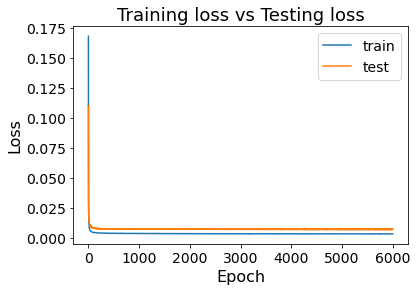

In [30]:
lr = 0.0001
EPOCHS = 6000 

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


pm25_pararcnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/pm25_cnn_sc1_4layer_{}h_no_sc.h5'.format(K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = pm25_pararcnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [31]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/pm25_cnn_sc1_4layer_{}h_no_sc.h5'.format(K))

In [32]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

error = inv_yhat - inv_y
print(error.shape)

inv_y.shape, inv_yhat.shape (8741, 24) (8741, 24)
(8741, 24)


In [33]:
print('MAE = {}'.format(float("{:.3f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.3f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 33.551
RMSE = 52.947
